In [18]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras import backend as k
import cv2
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.preprocessing.image import img_to_array

In [2]:
train_path = r'C:\Users\Mohamed Hamde\OneDrive - Culture and Science City\Desktop\final project/fruits_dataset/train'
test_path = r'C:\Users\Mohamed Hamde\OneDrive - Culture and Science City\Desktop\final project/fruits_dataset/test'
val_path = r'C:\Users\Mohamed Hamde\OneDrive - Culture and Science City\Desktop\final project/fruits_dataset/val'

In [3]:
img_train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True)
img_val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
img_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

In [4]:
train_batches = img_train_datagen.flow_from_directory(train_path, target_size=(224, 224), batch_size=32)

test_batches = img_test_datagen.flow_from_directory(test_path, target_size=(224, 224), batch_size=1367)

val_batches = img_val_datagen.flow_from_directory(val_path, target_size=(224, 224), batch_size=32)

Found 9516 images belonging to 6 classes.
Found 1367 images belonging to 6 classes.
Found 2716 images belonging to 6 classes.


In [5]:
X_train, y_train = next(train_batches)
X_test, y_test = next(test_batches)
X_val, y_val = next(val_batches)

In [12]:
labels = ['fresh apples', 'fresh banana', 'fresh oranges', 'rotten apples', 'rotten banana', 'rotten oranges']

In [6]:
model = tf.keras.applications.mobilenet.MobileNet()

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
for layer in model.layers:
    print(layer.name)

conv1
conv1_bn
conv1_relu
conv_dw_1
conv_dw_1_bn
conv_dw_1_relu
conv_pw_1
conv_pw_1_bn
conv_pw_1_relu
conv_pad_2
conv_dw_2
conv_dw_2_bn
conv_dw_2_relu
conv_pw_2
conv_pw_2_bn
conv_pw_2_relu
conv_dw_3
conv_dw_3_bn
conv_dw_3_relu
conv_pw_3
conv_pw_3_bn
conv_pw_3_relu
conv_pad_4
conv_dw_4
conv_dw_4_bn
conv_dw_4_relu
conv_pw_4
conv_pw_4_bn
conv_pw_4_relu
conv_dw_5
conv_dw_5_bn
conv_dw_5_relu
conv_pw_5
conv_pw_5_bn
conv_pw_5_relu
conv_pad_6
conv_dw_6
conv_dw_6_bn
conv_dw_6_relu
conv_pw_6
conv_pw_6_bn
conv_pw_6_relu
conv_dw_7
conv_dw_7_bn
conv_dw_7_relu
conv_pw_7
conv_pw_7_bn
conv_pw_7_relu
conv_dw_8
conv_dw_8_bn
conv_dw_8_relu
conv_pw_8
conv_pw_8_bn
conv_pw_8_relu
conv_dw_9
conv_dw_9_bn
conv_dw_9_relu
conv_pw_9
conv_pw_9_bn
conv_pw_9_relu
conv_dw_10
conv_dw_10_bn
conv_dw_10_relu
conv_pw_10
conv_pw_10_bn
conv_pw_10_relu
conv_dw_11
conv_dw_11_bn
conv_dw_11_relu
conv_pw_11
conv_pw_11_bn
conv_pw_11_relu
conv_pad_12
conv_dw_12
conv_dw_12_bn
conv_dw_12_relu
conv_pw_12
conv_pw_12_bn
conv_pw_12_relu

In [7]:
model = keras.models.load_model("fr.h5")

In [38]:
def get_class_activation_map(path, model, alpha, size, last_layer, channel, labels) :
    #path = path of images
    #model = model of deep learning
    #alpha = imshow(image, alpha)
    #size = size of image
    #last_layer = last layer in model deep learning
    #channel = number of channels in images , image = (3, 3, 1024)
    #labels = labels of model deep learning
   # ---------------------------------------------------------
    img = plt.imread(path)
    img = img[:, :, :3]
    img = cv2.resize(img, (size, size))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    #img = preprocess_input(img)
    #plt.imshow((img[0]))
    #plt.show()
    #---------------------------------------------------------
    pred = model.predict(img)
    target_class = np.argmax(pred[0])
   # ---------------------------------------------------------
    last_conv = model.get_layer(str(last_layer))
    grads = k.gradients(model.output[:,target_class], last_conv.output)[0]
   # ---------------------------------------------------------
    pooled_grads = k.mean(grads, axis=(0,1,2))
    iterate = k.function([model.input],[pooled_grads, last_conv.output[0]])
    pooled_grads_value, conv_layer_output = iterate([img])
    #---------------------------------------------------------
    for i in range(channel):
        conv_layer_output[:,:,i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output, axis=-1)
   # ---------------------------------------------------------
    for x in range(heatmap.shape[0]):
        for y in range(heatmap.shape[1]):
            heatmap[x,y] = np.max(heatmap[x,y],0)
    #---------------------------------------------------------
    heatmap = np.maximum(heatmap,0)
    heatmap /= np.max(heatmap)
    #---------------------------------------------------------
    img_heat = cv2.imread(path, 1)
    gray_img = cv2.cvtColor(img_heat, cv2.COLOR_BGR2GRAY)
    heatmap_img = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)
    fin = cv2.addWeighted(heatmap_img, 0.7, img_heat, 0.3, 0)
    #---------------------------------------------------------
    upsample = cv2.resize(heatmap, (size, size))
    #plt.imshow((img[0]))
    #plt.imshow(upsample,alpha= alpha)
    #plt.show()
    #---------------------------------------------------------
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(hspace=0.3, wspace=0.2)
    plt.tight_layout()
    
    
    plt.subplot(1, 3, 1)
    plt.imshow((img[0]))
    plt.title(labels[np.argmax(pred)])
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow((img[0]))
    plt.imshow(upsample,alpha= alpha)
    plt.title('GradCam')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(fin)
    plt.title('HeatMap')
    plt.axis('off')
    
    plt.show()

In [10]:
ls = []
for i in test_batches.filepaths:
    ls.append(i)

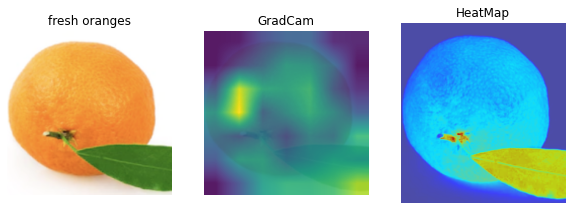

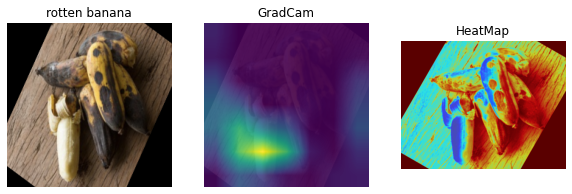

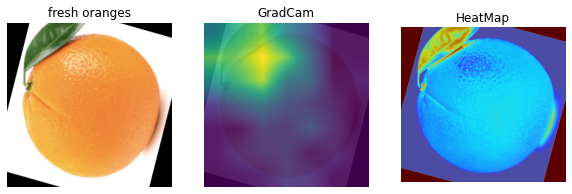

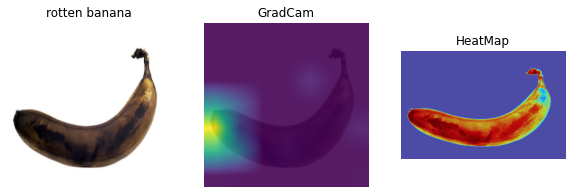

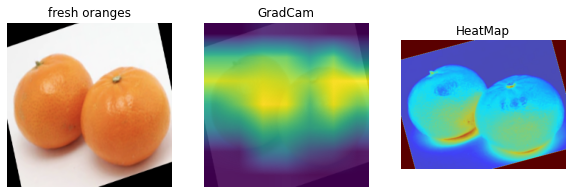

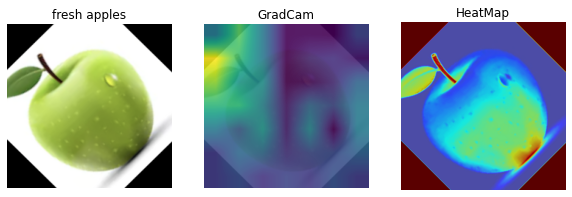

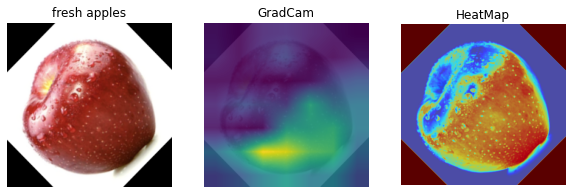

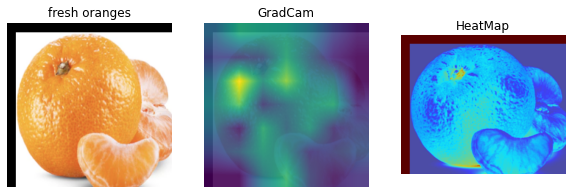

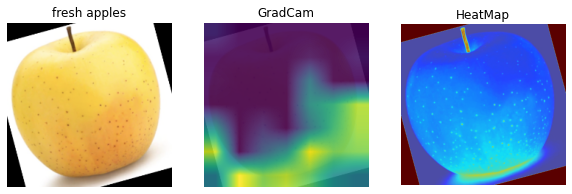

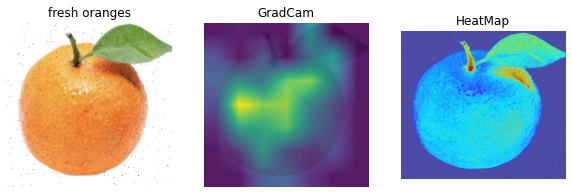

In [46]:
path = np.random.choice(ls, size=10)
for i in range(len(path)):
    get_class_activation_map(path= path[i], model= model, alpha= 0.9, size= 224, last_layer= 'conv_pw_13_relu', channel= 1024, labels= labels)

In [30]:
path_one = r'C:\Users\Mohamed Hamde\OneDrive - Culture and Science City\Desktop\b.jpg'

In [34]:
def get_class_activation_map_one_image(path, model, alpha, size, last_layer, channel) :
    
    img = plt.imread(path)
    img = cv2.resize(img, (size, size))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    plt.imshow((img[0]))
    plt.show()
    
    pred = model.predict(img)
    target_class = np.argmax(pred[0])
    
    last_conv = model.get_layer(str(last_layer))
    grads = k.gradients(model.output[:,target_class], last_conv.output)[0]
    
    pooled_grads = k.mean(grads, axis=(0,1,2))
    iterate = k.function([model.input],[pooled_grads, last_conv.output[0]])
    pooled_grads_value, conv_layer_output = iterate([img])
    
    for i in range(channel):
        conv_layer_output[:,:,i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output, axis=-1)
    
    for x in range(heatmap.shape[0]):
        for y in range(heatmap.shape[1]):
            heatmap[x,y] = np.max(heatmap[x,y],0)
    
    heatmap = np.maximum(heatmap,0)
    heatmap /= np.max(heatmap)
    
    upsample = cv2.resize(heatmap, (size, size))
    plt.imshow((img[0]))
    plt.imshow(upsample,alpha= alpha)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


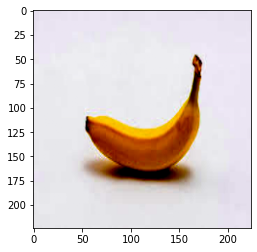

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


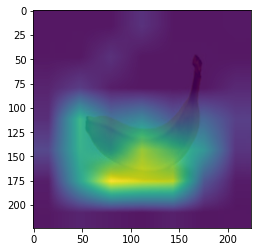

In [37]:
get_class_activation_map_one_image(path= path_one, model= model, alpha= 0.9, size= 224, last_layer= 'conv_pw_13_relu', channel= 1024)